## Import

In [1]:
import mne
#from ecgdetectors import Detectors
#from hrv import HRV
import numpy as np
from scipy import signal as sg
import pandas as pd
from matplotlib import pyplot as plt
#from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

## Load Data

In [2]:
raw = mne.io.read_raw_brainvision("20231019_B68_stroopv1_0002.vhdr")

# Reconstruct the original events from our Raw object
events, event_ids = mne.events_from_annotations(raw)

Extracting parameters from 20231019_B68_stroopv1_0002.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1']


In [3]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_channel_types({'ECG':'ecg'})
raw.set_channel_types({'vEOG':'eog'})
raw.set_channel_types({'hEOG':'eog'})

<RawBrainVision | 20231019_B68_stroopv1_0002.eeg, 67 x 953760 (953.8 s), ~60 kB, data not loaded>

## ECG Analysis

In [4]:
#Testing only on ECG
#raw_ecg = raw.crop(tmin = 60, tmax = 120).copy().pick_types(eeg=False, eog=False, ecg=True) #make a copy
raw_ecg = raw.crop(tmin = 34.047, tmax = 934.062).copy().pick_types(eeg=False, eog=False, ecg=True) #make a copy
#raw_ecg = raw.copy().pick_types(eeg=False, eog=False, ecg=True) #make a copy
#ecgevents,_,_ = mne.preprocessing.find_ecg_events(raw_ecg, l_freq=5, h_freq=15)
#raw_ecg.plot(events=ecgevents)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [5]:
fs = 1000
mne_ecg, mne_time = raw_ecg[:]
mne_ecg = mne_ecg.T #Transpose 
print(type(mne_ecg)), print(type(mne_time))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


(None, None)

## Pan Tompkins Algorithm

In [6]:
class pan_tompkins_qrs():

    def bpf(self,x):
        
        
        
        y_filtered = None

        #Results will be delayed 16 Samples
        y = x.copy()

        #Low Pass Filter
        #y(n) = 2y(n-1) - y(n-2) + x(n) - 2x(n-6) + x(n-12)
        for n in range(len(x)):
            y[n] = x[n]

            if (n >= 1):
                y[n] += 2*y[n-1]
            if (n >= 2):
                y[n] -= y[n-2]
            if (n >= 6):
                y[n] -= 2*x[n-6]
            if (n >= 12):
                y[n] += x[n-12]
        
        y_filtered = y.copy()

        #High Pass Filter
        #y(n) = 32x(n-16) - y(n-1) - x(n) + x(n-32)
        for n in range(len(x)):
            y_filtered[n] = -1*y[n]

            if (n >= 1):
                y_filtered[n] -= y_filtered[n-1]
            if (n >= 16):
                y_filtered[n] += 32*y[n-16]
            if(n >= 32):
                y_filtered[n] += y[n-32]
        
        #Normalization
        max_val = max(max(y_filtered), -min(y_filtered))
        y_filtered = y_filtered/max_val

        return y_filtered
    
    def derivative(self,x,fs):
        
        #Results will be delayed for 2 samples
        y_derived = x.copy()
        
        #Derivative Filter
        #y(n) = [-x(n-2) - 2x(n-1) + 2x(n+1) + x(n+2)]/8
        for n in range(len(x)):
            y_derived[n] = 0

            if (n >= 1):
                y_derived[n] -= 2*x[n-1]
            if (n >= 2):
                y_derived[n] -= x[n-2]
            
            ###Not sure what this part is for###
            if (n >= 2 and n <= len(x)-2):
                y_derived[n] += 2*x[n+1]
            if (n >= 2 and n<= len(x)-3):
                y_derived[n] += x[n+2]
            ###Not sure what this part is for###

            ###Not sure why does it has to be times to "fs"###
            y_derived[n] = (y_derived[n]*fs)/8
            ###Not sure why does it has to be times to "fs"###
        
        return y_derived
    
    def squaring(self,x):
        
        y_squared = x.copy()

        for n in range(len(x)):
            y_squared[n] = x[n]**2

        return y_squared
    
    def moving_window_integration(self,x,fs):
        # Initialize result and window size for integration
        y = x.copy()
        win_size = round(0.150 * fs)
        sum = 0

        # Calculate the sum for the first N terms
        for j in range(win_size):
            sum += x[j]/win_size
            y[j] = sum
        
        # Apply the moving window integration using the equation given
        for n in range(win_size,len(x)):  
            sum += x[n]/win_size
            sum -= x[n-win_size]/win_size
            y[n] = sum

        return y

    def solve(self,x,fs):

        # Convert the input signal into numpy array
        input_signal = x.copy()

        # Bandpass Filter
        global bpass
        bpass = self.bpf(input_signal.copy())

        # Derivative Function
        global der
        der = self.derivative(bpass.copy(),fs)

        # Squaring Function
        global sqr
        sqr = self.squaring(der.copy())

        # Moving Window Integration Function
        global mwin
        mwin = self.moving_window_integration(sqr.copy(),fs)

        return mwin

### Processing Signals

In [7]:
QRS_detector = pan_tompkins_qrs()
output = QRS_detector.solve(mne_ecg, fs)

### Plotting Processed Signals Graph

Text(0.5, 1.0, 'Moving Window Integrated Signal')

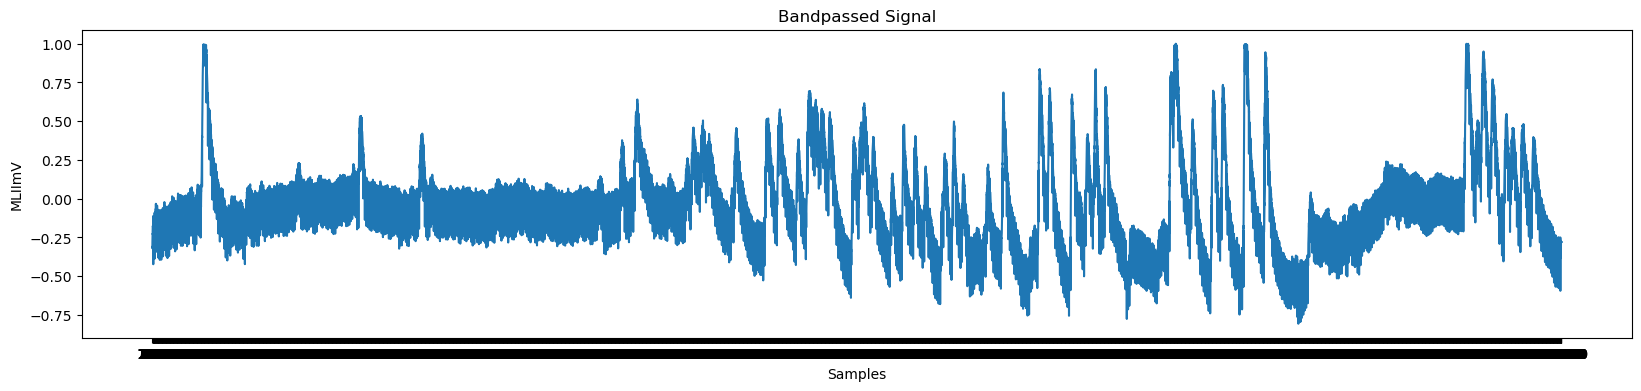

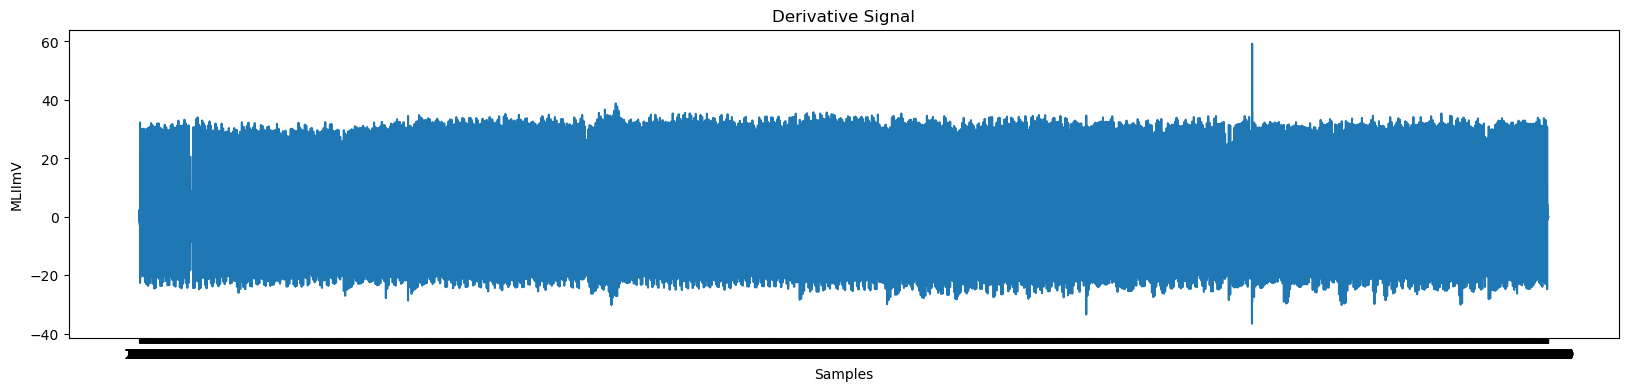

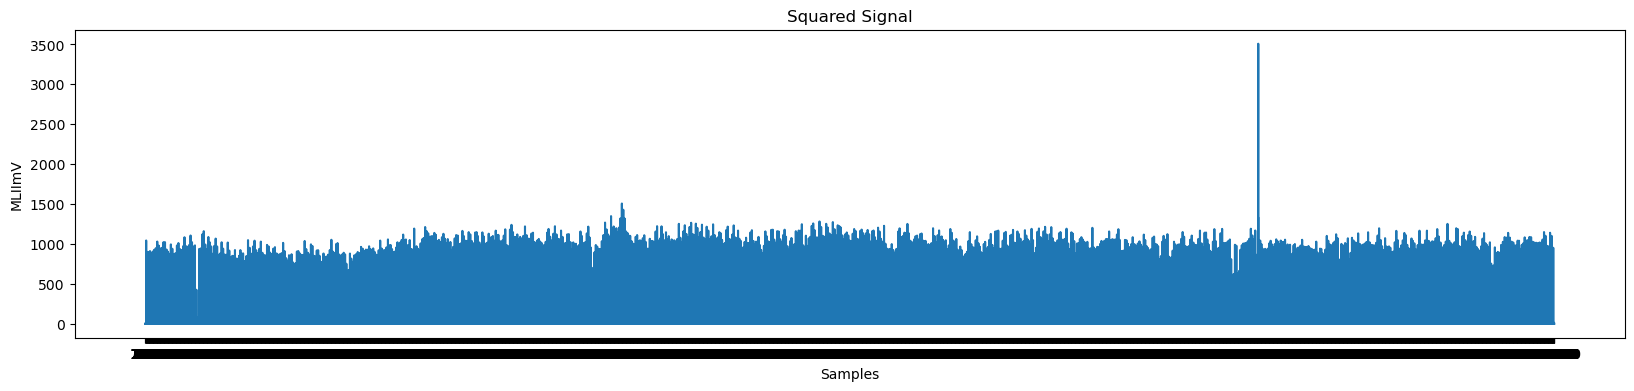

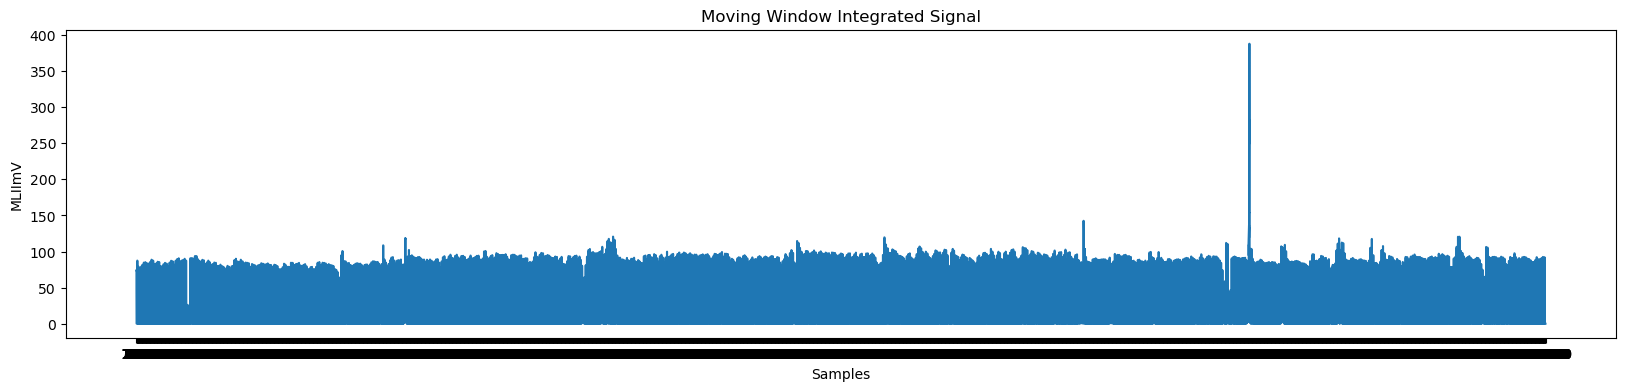

In [8]:
# Plotting bandpassed signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(bpass)+1, 150))
plt.plot(bpass[32:len(bpass)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Bandpassed Signal")

# Plotting derived signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(der)+1, 150))
plt.plot(der[32:len(der)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Derivative Signal")

# Plotting squared signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(sqr)+1, 150))
plt.plot(sqr[32:len(sqr)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Squared Signal")

# Plotting moving window integrated signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(mwin)+1, 150))
plt.plot(mwin[100:len(mwin)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Moving Window Integrated Signal")

In [12]:
slopes = sg.fftconvolve(mwin[16:], np.full((25,), 1) / 25, mode='same')

ValueError: in1 and in2 should have the same dimensionality

In [25]:
slopes = sg.fftconvolve(mwin.reshape(mwin.shape[0], -1), np.full((25,1),1)/25, mode='same')

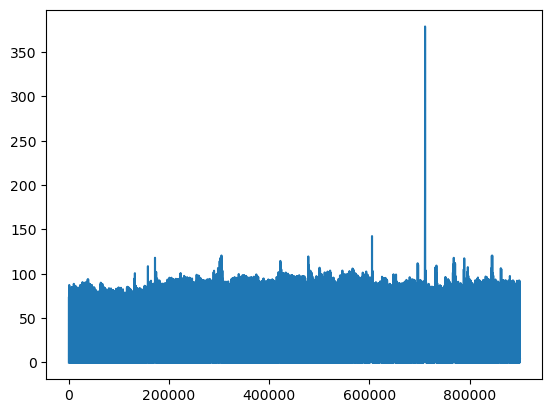

In [27]:
plt.plot(slopes)

### Finding Heart Rate 

In [ ]:
from scipy import signal as sg

class heart_rate():
    def __init__(self,x,fs):
        #Initialize Variables
        self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
        self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

        self.T_wave = False
        self.m_win = mwin
        self.b_pass = bpass
        self.fs = fs
        self.signal = x
        self.win_150ms = round(0.15*self.fs)

        self.RR_Low_Limit = 0
        self.RR_High_Limit = 0
        self.RR_Missed_Limit = 0
        self.RR_Average1 = 0

    def approx_peak(self):
        ###Change from the original code by making the size to (A x 1) instead of (A x )###
        slopes = sg.fftconvolve(self.m_win, np.full((25,1),1)/25, mode='same')
        ###Change from the original code by making the size to (A x 1) instead of (A x )###

        for i in range(round(0.5*self.fs) + 1,len(slopes)-1):
            if (slopes[i] > slopes[i-1]) and (slopes[i+1] <slopes[i]):
                self.peaks.append(i)

    def adjust_rr_interval(self, ind):
        self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.fs  

        # Calculating RR Averages
        self.RR_Average1 = np.mean(self.RR1)
        RR_Average2 = self.RR_Average1
        
        # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
        if (ind >= 8):
            for i in range(0, 8):
                if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                    self.RR2.append(self.RR1[i])

                    if (len(self.RR2) > 8):
                        self.RR2.remove(self.RR2[0])
                        RR_Average2 = np.mean(self.RR2)    

        # Adjusting the RR Low Limit and RR High Limit
        if (len(self.RR2) > 7 or ind < 8):
            self.RR_Low_Limit = 0.92 * RR_Average2        
            self.RR_High_Limit = 1.16 * RR_Average2
            self.RR_Missed_Limit = 1.66 * RR_Average2
    
    def searchback(self, peak_val, RRn, sb_win):
        # Check if the most recent RR interval is greater than the RR Missed Limit
        if (RRn > self.RR_Missed_Limit):
            # Initialize a window to searchback  
            win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

            # Find the x locations inside the window having y values greater than Threshold I1             
            coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
                for pos in coord:
                    if (win_rr[pos] == max(win_rr[coord])):
                        x_max = pos
                        break
            else:
                x_max = None
    
            # If the max peak value is found
            if (x_max is not None):   
                # Update the thresholds corresponding to moving window integration
                self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
                self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
                self.Threshold_I2 = 0.5 * self.Threshold_I1         

                # Initialize a window to searchback 
                win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

                # Find the x locations inside the window having y values greater than Threshold F1                   
                coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

                # Find the x location of the max peak value in the search window
                if (len(coord) > 0):
                for pos in coord:
                    if (win_rr[pos] == max(win_rr[coord])):
                        r_max = pos
                        break
                else:
                r_max = None

                # If the max peak value is found
                if (r_max is not None):
                # Update the thresholds corresponding to bandpass filter
                if self.b_pass[r_max] > self.Threshold_F2:                                                        
                    self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                    self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                    self.Threshold_F2 = 0.5 * self.Threshold_F1      

                    # Append the probable R peak location                      
                    self.r_locs.append(r_max)

    def find_t_wave(self,peak_val,RRn,ind,prev_ind):
        '''
        T Wave Identification
        :param peak_val: peak location in consideration
        :param RRn: the most recent RR interval
        :param ind: current index in peaks array
        :param prev_ind: previous index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            if (ind > 0 and 0.20 < RRn < 0.36):
            # Find the slope of current and last waveform detected        
            curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
            last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
            
            # If current waveform slope is less than half of last waveform slope
            if (curr_slope < 0.5*last_slope):  
                # T Wave is found and update noise threshold                      
                self.T_wave = True                             
                self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

            if (not self.T_wave):
                # T Wave is not found and update signal thresholds
                if (self.probable_peaks[ind] > self.Threshold_F1):   
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                    self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                    # Append the probable R peak location
                    self.r_locs.append(self.probable_peaks[ind])  

                else:
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                    self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

        # Update noise thresholds
        elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def adjust_thresholds(self,peak_val,ind):
        '''
        Adjust Noise and Signal Thresholds During Learning Phase
        :param peak_val: peak location in consideration
        :param ind: current index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            # Update signal threshold
            self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

            if (self.probable_peaks[ind] > self.Threshold_F1):                                            
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                # Update noise threshold
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
            
        # Update noise thresholds    
        elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def update_thresholds(self):
        '''
        Update Noise and Signal Thresholds for next iteration
        '''

        self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
        self.Threshold_I2 = 0.5 * self.Threshold_I1 
        self.Threshold_F2 = 0.5 * self.Threshold_F1
        self.T_wave = False 


    def ecg_searchback(self):
        '''
        Searchback in ECG signal to increase efficiency
        '''

        # Filter the unique R peak locations
        self.r_locs = np.unique(np.array(self.r_locs).astype(int))

        # Initialize a window to searchback
        win_200ms = round(0.2*self.fs)
    
        for r_val in self.r_locs:
            coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

            # Find the x location of the max peak value
            if (len(coord) > 0):
            for pos in coord:
                if (self.signal[pos] == max(self.signal[coord])):
                    x_max = pos
                    break
            else:
            x_max = None

            # Append the peak location
            if (x_max is not None):   
            self.result.append(x_max)


    def find_r_peaks(self):
        '''
        R Peak Detection
        '''

        # Find approximate peak locations
        self.approx_peak()

        # Iterate over possible peak locations
        for ind in range(len(self.peaks)):

            # Initialize the search window for peak detection
            peak_val = self.peaks[ind]
            win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
            max_val = max(self.b_pass[win_300ms], default = 0)

            # Find the x location of the max peak value
            if (max_val != 0):        
            x_coord = np.asarray(self.b_pass == max_val).nonzero()
            self.probable_peaks.append(x_coord[0][0])
            
            if (ind < len(self.probable_peaks) and ind != 0):
                # Adjust RR interval and limits
                self.adjust_rr_interval(ind)
                
                # Adjust thresholds in case of irregular beats
                if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                    self.Threshold_I1 /= 2
                    self.Threshold_F1 /= 2

                RRn = self.RR1[-1]

                # Searchback
                self.searchback(peak_val,RRn,round(RRn*self.fs))

                # T Wave Identification
                self.find_t_wave(peak_val,RRn,ind,ind-1)

            else:
            # Adjust threholds
            self.adjust_thresholds(peak_val,ind)

            # Update threholds for next iteration
            self.update_thresholds()

        # Searchback in ECG signal 
        self.ecg_searchback()

        return self.result
        
    
    

C:\Users\jeje_\AppData\Local\Temp\ipykernel_28324\1664120787.py:145: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
C:\Users\jeje_\AppData\Local\Temp\ipykernel_28324\1664120787.py:146: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
C:\Users\jeje_\AppData\Local\Temp\ipykernel_28324\1664120787.py:149: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (curr_slope < 0.5*las

Heart Rate 65.93384592968614 BPM


Text(0.5, 1.0, 'R Peak Locations')

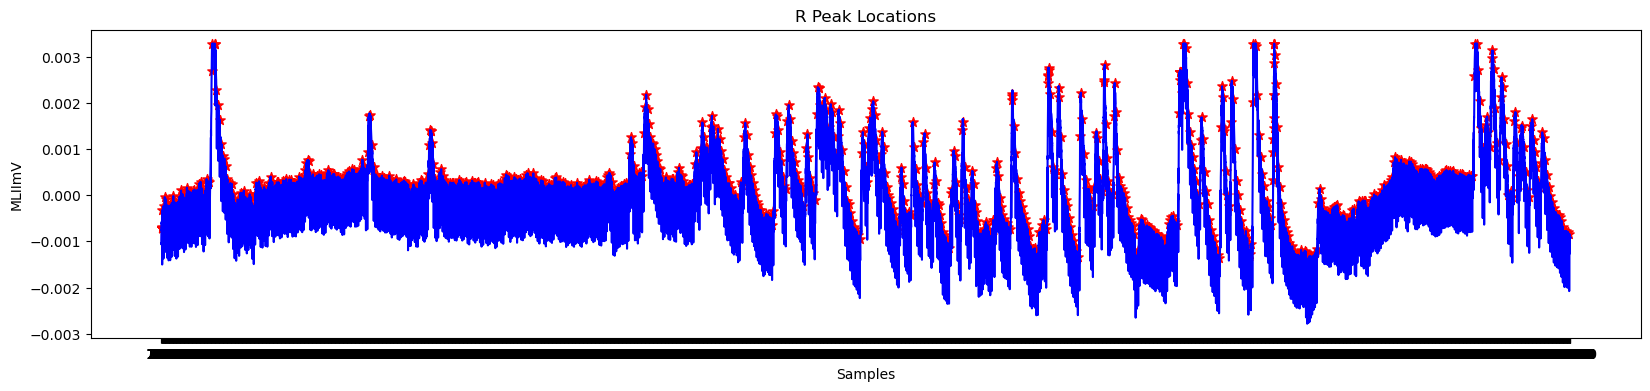

In [30]:
# Convert ecg signal to numpy array
signal = mne_ecg.copy()

# Find the R peak locations
hr = heart_rate(signal,fs)
result = hr.find_r_peaks()
result = np.array(result)

# Clip the x locations less than 0 (Learning Phase)
result = result[result > 0]

# Calculate the heart rate
heartRate = (60*fs)/np.average(np.diff(result[1:]))
print("Heart Rate",heartRate, "BPM")

# Plotting the R peak locations in ECG signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(signal)+1, 150))
plt.plot(signal, color = 'blue')        
plt.scatter(result, signal[result], color = 'red', s = 50, marker= '*')
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("R Peak Locations")

#### Unused, ECG Detection Library